# Classification of Images with Masks using Machine Learning

The data set from https://www.kaggle.com/rakshana0802/face-mask-detection-data consists of a total of 3833 images (1915 images of people wearing face masks, and 1918 images of people without face masks). The goal of this project is to train sufficient data with various machine learning algorithms and analyze/compare the accuracy and efficiency of each classification method.

## Data Cleaning

The first problem that I faced was that the images in the data set came in different sizes (some larger than others), file types (.PNG, .JPG, .JPEG), modes (images come in P, RGB, and RGBA modes). The difference in file types and modes is especially prevalent among images of people with face masks. Hence, I wrote a program `img2vec.py` that transforms all images to a standard size, file type, and mode. The so-called "standard" can be easily changed at the top of the program in `img2vec.py`. The output of this data is a `mask.csv` file, where the first column in the file corresponds to the class of each image (with or without mask) and the rest of the columns corresponds to the pixel value in a specific row/column of the transformed images.

Note that I have also written the program `vec2img.py` that allows the viewing of the transformed images.

## Increasing the Number of Data

One of the issues I faced in the project is the slight lack of data. The reasons are as follows:

1) In order for the classifiers to produce a better generalization in classifying the data, more training data has to be provided. This would mean that I will have to sacrifice the number of testing data. 

2) Similarly, the reverse is also true. I would like to see how my classifiers fare in general, and having a small testing data set can lead to higher than normal accuracies.

3) In certain classification methods (eg. Neural Network), I would like to use some validation data while training my model. This further reduces my training/testing data set.

In order to solve the above issues, I doubled the number of data by horizontally flipping each image in the given data set. Eg. image $i$ is an image of a person facing to the right. The image is then flipped such that the person is now facing to the left. I then convert both images into matrices of its respective pixel values before adding them into the data frame which is later sent to `mask.csv`.

### Machine Learning Algorithms Used:

* Support Vector Machines

* Classification via Singular Value Decomposition (SVD) Properties

* Logistic Regression

* Linear Discriminant Analysis (LDA)

* Random Forest/Decision Trees

* Neural Network

### Code to import `mask.csv` into a dataframe and sort into training and test data

In [1]:
PERCENTAGE_OF_TRAIN = 0.8

import pandas as pd
import random
import math as m
import numpy as np

# import mask.csv
full_data = pd.read_csv('mask.csv', header = 0)

# split into two separate data frames by images with and without masks
with_mask = full_data[full_data.with_mask == 'Yes']
without_mask = full_data[full_data.with_mask == 'No']

# randomly select training data index
# the amount of training data to be selected depends on the value input into the variable PERCENTAGE_OF_TRAIN
trainidx_withmask = random.sample(range(len(with_mask)), m.floor(PERCENTAGE_OF_TRAIN * len(with_mask)))
trainidx_withoutmask = random.sample(range(len(without_mask)), m.floor(PERCENTAGE_OF_TRAIN * len(without_mask)))

# remaining data will be used as testing data
testidx_withmask = list(set(list(range(len(with_mask)))) - set(trainidx_withmask))
testidx_withoutmask = list(set(list(range(len(without_mask)))) - set(trainidx_withoutmask))

# build a data frame of training data
train_withmask = with_mask.iloc[trainidx_withmask, :]
train_withoutmask = without_mask.iloc[trainidx_withoutmask, :]
train_data = pd.concat([train_withmask, train_withoutmask], axis = 0).reset_index(drop = True)

# build a data frame of testing data
test_withmask = with_mask.iloc[testidx_withmask, :]
test_withoutmask = without_mask.iloc[testidx_withoutmask, :]
test_data = pd.concat([test_withmask, test_withoutmask], axis = 0).reset_index(drop = True)

# converting the data frame into arrays to be used to run ML algorithms
train_x = np.array(train_data.iloc[:, 1:])
train_y = np.array(train_data.iloc[:, 0])

test_x = np.array(test_data.iloc[:, 1:])
test_y_true = np.array(test_data.iloc[:, 0])

In [36]:
%store train_x
%store train_y
%store test_x
%store test_y_true

Stored 'train_x' (ndarray)
Stored 'train_y' (ndarray)
Stored 'test_x' (ndarray)


UsageError: Unknown variable 'test_y'


### Code to plot confusion matrices later on

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def plot_confmat(clf, X, y):
    (fig, (ax1, ax2)) = plt.subplots(1,2, figsize=(10, 5))
    disp1 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = None, ax = ax1)
    disp2 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = 'true', ax = ax2)
    disp1.ax_.set_title('Non-normalized Confusion Matrix')
    disp2.ax_.set_title('Normalized Confusion Matrix')
    disp2.im_.set_clim(0,1)
    return disp1.confusion_matrix

In [ ]:
%store plot_confmat

### Code to analyze classification result later on

In [3]:
classification_result = {}

In [ ]:
%store classification_result

## Support Vector Machines (SVM)

The general idea of how a Support Vector Machine works is that an $n-1$ dimension hyperplane is "drawn" on an $n$ dimension "plot" to split the data into two (or more) classes. It is constructed such that the distance between each data point and the hyperplane is at its furthest. The hyperplane can be expressed as the following equation:
$$w^T x + b = 0$$
where $w \in \mathbb{R}^{n-1}$ and $b \in \mathbb{R}$. The data points with parameter values $x_i$ where $w^T x_i + b < 0$ will be classified into one class and the data points that give us $w^T x_i + b > 0$ will be classified into the other class. Running the SVM when our data points are linearly separable (ie. data points can be classified by drawing a straight hyperplane) is extremely simple. Problems arise when data points aren't linearly separable, which is the case for most classification problems.

The simple solution when the data points are not linearly separable is to simply increase the dimensions of the data set to a point where our data is linearly separable. However, this simple solution can be very time and energy consuming, especially when we have more than 10,000 parameters in this case. To tackle this problem, we can use what is called "kernel tricks".

By definition, "a function that takes as inputs vectors in the original space and returns the dot product of the vectors in the feature space is called a kernel function". In other words, if we have $x,z \in X$ and the map $\phi: x \rightarrow \mathbb{R}^N$ then 
$$k(x,z) = \langle \phi(x), \phi(z) \rangle$$
is a kernel function. (The Kernel Trick in Support Vector Classification, Towards Data Science)

The above definition and function will be the key to solving non-linear classification problems. 

Note that the solution of the dual problem can is always in the following form (refer to Aarti Singh's slides for better explanation):
$$w^* = \sum_{i = 1}^{N} \alpha_i y_i x_i$$
where $N$ is the number of data points used to run the SVM and $y_i$ is the class (either 1 or -1) of data $i$. Recall the hyperplane equation that was previously mentioned, we have now found the solution $w^*$ that gives us the separation hyperplane for the SVM classification. Substituting $w^*$ into the hyperplane equation, we get 
$$\sum_{i = 1}^{N} \alpha_i y_i (x_i^T x) + b$$

Now, we can make predictions with the above equation. Just like before, if $\sum_{i = 1}^{N} \alpha_i y_i (x_i^T x) + b > 0$, we will assign it to one of the class, and if $\sum_{i = 1}^{N} \alpha_i y_i (x_i^T x) + b < 0$ we will assign it to the other. Here is where the kernel trick comes into play. We want to map the input vectors $x_i$ and $x$ into a feature space, and we can do so by making the following tweak into the equation:
$$\sum_{i = 1}^{N} \alpha_i y_i (\phi(x_i)^T \phi(x)) + b$$

This then gives us
$$\sum_{i = 1}^{N} \alpha_i y_i \langle \phi(x_i), \phi(x)\rangle + b \text{ or } \sum_{i = 1}^{N} \alpha_i y_i k(x_i, x) + b$$

The same classification decision is done to predict the classes of each test data. 

The next question that generally arises is: What is $k(x,z)$ or $\phi (x)$? This will be answered in each of the following subsections.

### Linear Kernel

In this simple case, $k(x,z) = x^T z$, which is equivalent to not using a kernel trick.

The code below is used to run SVM with a linear kernel. 

Time taken: 3926.49 seconds


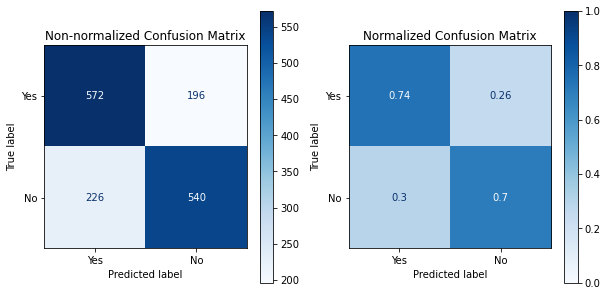

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import time

start = time.time()
classifier1 = SVC(kernel = 'linear', C = 1)
classifier1.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier1, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Linear'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

In [ ]:
%store classification_result

The change in the regularization parameter `C` does not change the results at all. However, there are slight differences in the time taken to complete the classification tasks. 

On the other hand, it seems that standardizing the variables (pixels of images in this case) does help improve the true positive rate very slightly, but the overall error rate has increased as well. Hence, standardizing the variables in this case is not a good option.

### RBF Kernel

In this case, $k(x,z) = \exp (- \gamma ||x - z||^2)$, where $\gamma > 0$.

The code below is used to run SVM with an RBF kernel.

Time taken: 6594.52 seconds


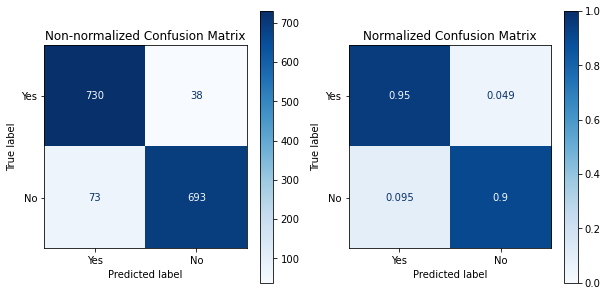

In [5]:
start = time.time()
classifier2 = SVC(kernel = 'rbf', cache_size = 500, C = 10)
classifier2.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier2, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - RBF'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

In [ ]:
%store classification_result

The change in the regularization parameter `C` in this case results in a more significant difference. In this case, setting `C = 10` produces the best results. However, the time taken to produce such results is still quite long.

### Polynomial Kernel Degree 2

In the next two cases, we have $k(x,z) = (x^T z + c)^d$ to be our kernel function, where $c$ is a constant that can be added, and $d$ is degree of the polynomial. In this current case, $d = 2$, while the next case is set to be $d = 3$.

The code below is used to run SVM with a polynomial kernel of degree 2.

Time taken: 4457.34 seconds


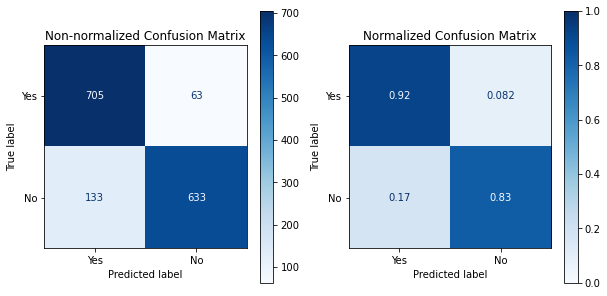

In [6]:
start = time.time()
classifier3 = SVC(kernel = 'poly', degree = 2)
classifier3.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier3, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Degree 2'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

In [ ]:
%store classification_result

### Polynomial Kernel Degree 3

The code below is used to run SVM with a polynomial kernel of degree 3.

Time taken: 3886.92 seconds


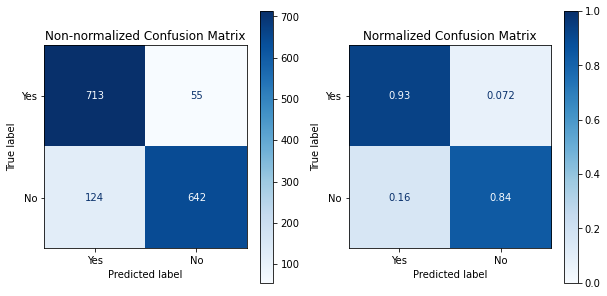

In [7]:
start = time.time()
classifier4 = SVC(kernel = 'poly', degree = 3, cache_size = 500)
classifier4.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier4, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Degree 3'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

In [ ]:
%store classification_result

Running the SVM classifier with a polynomial kernel is significantly faster that the rest of the SVM kernels. Additionally, the error rate produced is not too bad either (slightly larger that that of the RBF kernel). The polynomial kernel of degree 2 can be chosen if the importance of speed outweights the importance of accuracy.

### Sigmoid Kernel

In this case, $k(x,z) = \tanh(\alpha x^T z + c)$.

The code below isused to run SVM with a sigmoid kernel.

Time taken: 2866.7 seconds


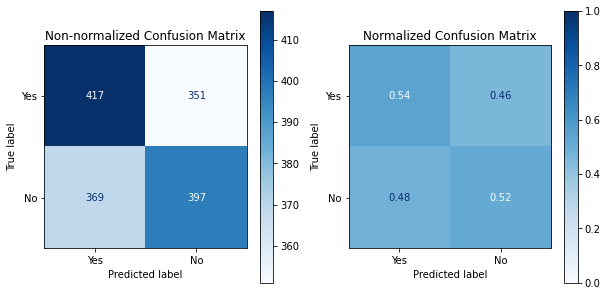

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start = time.time()
classifier5 = make_pipeline(StandardScaler(), SVC(kernel = 'sigmoid'))
classifier5.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier5, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Sigmoid'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

In [ ]:
%store classification_result

The SVM classifier fares worst with the sigmoid kernel. Its accuracy is far lower than when using any of the other SVM kernels.

## Classification via Singular Value Decomposition properties

We now move on to classifying the images via properties of SVD. 

The function below is used to separate the training data into two matrices, one for images of class 'Yes' and the other for images of class 'No'. Then, the function returns the SVD matrices of each class matrix.

In [9]:
import scipy as sc

def classify_svd_training(train_mat, train_class):
    X = train_mat.T
    y = train_class.T
    
    U = [[], []]
    S = [[], []]
    V = [[], []]
    for i, class_val in enumerate(['Yes', 'No']):
        index = (y == class_val)
        matrix = X[:, index]
        (U[i], S[i], V[i]) = sc.linalg.svd(matrix, full_matrices = False)
    return (U, S, V)        

In [ ]:
%store classify_svd_training

The function below used to classify our test data runs the following:

1) We take a test data point and convert it into a vector. Let's call this the vector $b$.

2) After performing SVD on the training data set in the previous section, we get the following:

$$A_i = U_i \Sigma_i V_i^T$$

* $A_i$ is the $m \times n$ training data matrix of class $i$ ($m$ represents the number of pixels in the image and $n$ represents the number of training data). Note that the value of $m$ is constant for all images since we have already transformed each image to a standard size. 

* $U_i$ is an $m \times r$ matrix where each column is orthonormal to one another.

* $\Sigma_i$ is an $r \times r$ matrix where the diagonals are singular values of $A_i$. The singular values in $\Sigma_i$ is ordered in descending order in the diagonals of the matrix.

* $V_i$ is an $n \times r$ matrix where each column is orthonormal to one another.

Now, we can think of the SVD of $A_i$ as organizing the data in the matrix $A_i$ in the sense that the most important components of $A_i$ (or the important details of images of class $i$) are arranged in the first few columns of $U_i, \Sigma_i, V_i$. On the other hand, the least important components of $A_i$ (or the white noises in the images of class $i$) are arranged in the last few columns of $U_i, \Sigma_i, V_i$. 

With this in mind, we want to select $k$ columns of data from $U_i$ to perform our classification. Let's call this version of $U_i$ with only $k$ columns as $U'_i$. We now want to find the vector $x$ such that 

$$U'_i x = b$$

However, since $U'_i$ is not invertible, we get $x$ by solving the normal equation

$$({U'_i}^T U'_i) x = {U'_i}^T b$$

After we manage to obtain $x$, we want to find the norm of the residual vector $r_i = b - U'_i x$.

3) Assuming we ran part (2) with the training matrix for the class 'Yes', run part (2) again with the training matrix for the class 'No' (or vice versa). We should now have the norms of both residual vectors $r_i$. Compare the norms and classify the test data point to the class with the smaller residual norm. Ie. if $||r_{Yes}|| < ||r_{No}||$ then we classify the test data point into the class 'Yes'.

4) Repeat the steps in parts (1) to (3) for each of the test data points. We now have our set of predictions and can compare them with their actual classes.

In [10]:
def classify_test(test_mat, n, U):
    X = test_mat.T
    test_size = X.shape[1]
    classification = []
    for i in range(test_size):
        b = X[:, i]
        resnorm = np.empty(2)
        for j in range(2):
            A = U[j][:,:n]
            x = np.linalg.inv(A.T @ A) @ A.T @ b
            res = b - A @ x
            resnorm[j] = np.linalg.norm(res, 2) / np.linalg.norm(b, 2)
        if resnorm[0] < resnorm[1]:
            classification.append('Yes')
        else:
            classification.append('No')
    return classification

In [ ]:
%store classify_test

The code below is used to find the SVD of both class matrices.

In [11]:
from sklearn.metrics import confusion_matrix

start = time.time()
(train_U, train_S, train_V) = classify_svd_training(train_x, train_y)
end = time.time()
time_taken = end - start
svd_train_time = time_taken

print('Time taken:', round(time_taken, 2), 'seconds')

Time taken: 155.4 seconds


In [ ]:
%store train_U
%store train_S
%store train_V
%store svd_train_time

### Magnitude of Singular Values of both classes

The following figures are plotted to give us an idea of the range of values of $k$ we should use to form $U'_i$. Recall that choosing a $k$ too small means that we miss out on important components of the training images and can negatively impact classification accuracy. Similarly, selecting a $k$ too large means that we include unnecessary components and white noise of the training images into our classifications, which can lower our predictive accuracy as well.

C:\Users\LZFun\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


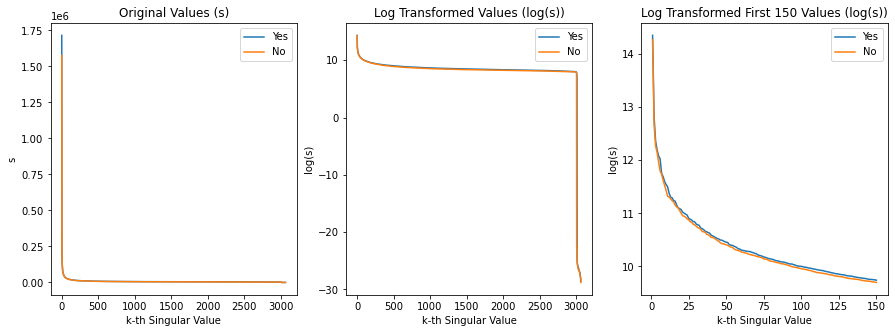

In [12]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))

x1 = list(range(1,len(train_S[0])+1))
y1 = train_S[0]
ax[0].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = train_S[1]
ax[0].plot(x2, y2, label = 'No')

ax[0].set_xlabel('k-th Singular Value')
ax[0].set_ylabel('s')
ax[0].title.set_text('Original Values (s)')
ax[0].legend()

x1 = list(range(1,len(train_S[0])+1))
y1 = np.log(train_S[0])
ax[1].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = np.log(train_S[1])
ax[1].plot(x2, y2, label = 'No')

ax[1].set_xlabel('k-th Singular Value')
ax[1].set_ylabel('log(s)')
ax[1].title.set_text('Log Transformed Values (log(s))')
ax[1].legend()

x1 = list(range(1,151))
y1 = np.log(train_S[0][:150])
ax[2].plot(x1, y1, label = 'Yes')

x2 = list(range(1, 151))
y2 = np.log(train_S[1][:150])
ax[2].plot(x2, y2, label = 'No')

ax[2].set_xlabel('k-th Singular Value')
ax[2].set_ylabel('log(s)')
ax[2].title.set_text('Log Transformed First 150 Values (log(s))')
ax[2].legend()

fig.show()

As we can see in the first figure above, the change in magnitude of the singular values is so large that it is hard to tell which value of $k$ we should choose. 

We then proceeded to take the natural log of each singular value and plot the same figure. The results (shown in the middle figure) shows that there is a sharp dip at around 2700. This means that the singular values occurring after 2700 all correspond to white noises. Additionally, we also see a huge change in the magnitudes of singular values at around 200. 

This brings us to the last figure on the right. In this case, we can see that there is no straightforward way to tell which exact value of $k$ to choose. Hence, I have decided to run the predictions with $k = 5, 10, 15, \ldots, 600$ below and plot a figure of accuracy vs prediction time based on the different values of $k$. 

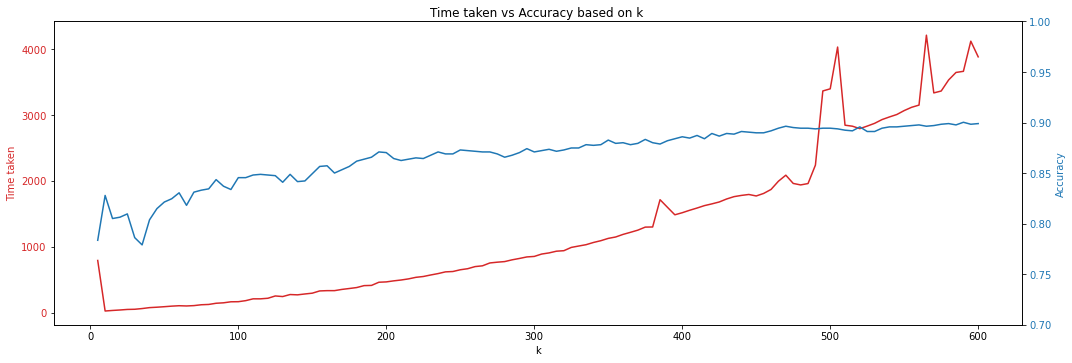

In [13]:
time_taken = []
accuracy = []
n = list(range(5,601,5))

for i in n:
    start = time.time()
    test_y_pred = classify_test(test_x, i, train_U)
    end = time.time()
    time_taken.append(round(end - start, 2))
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'])
    acc = (confmat[0][0] + confmat[1][1]) / np.sum(confmat)
    accuracy.append(acc)

fig, ax1 = plt.subplots(figsize = (15,5))

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Time taken', color=color)
ax1.plot(n, time_taken, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(n, accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.7,1])

fig.suptitle('Time taken vs Accuracy based on k', y = 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
%store time_taken
%store accuracy

As we can see in the figure above, the time taken to predict increases exponentially as the value of $k$ increases. This is accompanied by slight increase or decrease in accuracy. In this case, we can say that when $k = 545$, we have our most accurate prediction using this classification method. However, when $k = 155$, we seem to get a similar result, but at a significantly shorter amount of time.

Overall, if we do not have the luxury to run the above code to find the accuracy of each $k$, it is best to just randomly select a $k$-value between 150 and 200 as the prediction accuracies between those values start to stabilize (less fluctuation) and take a relatively short amount of time too.

Time taken: 3599.55 seconds


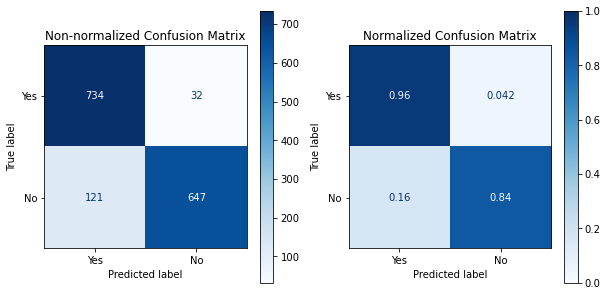

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

k_singularval = (accuracy.index(max(accuracy)) + 1) * 5
varname = 'SVD - ' + str(k_singularval)

start = time.time()
test_y_pred = classify_test(test_x, k_singularval, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result[varname] = {'Time' : svd_train_time + time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)
        


Time taken: 377.69 seconds


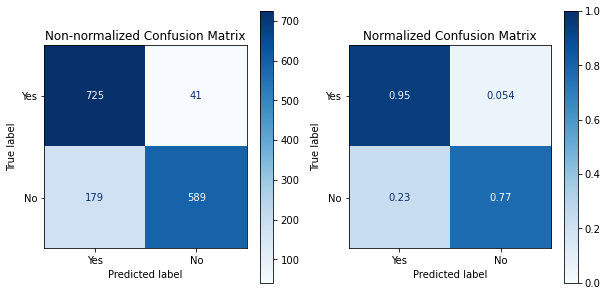

In [15]:
k_singularval = (accuracy.index(max(accuracy[:40])) + 1) * 5
varname = 'SVD - ' + str(k_singularval)

start = time.time()
test_y_pred = classify_test(test_x, 155, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result['SVD - 155'] = {'Time' : svd_train_time + time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

In [ ]:
%store classification_result

## Logistic Regression

Before the start of training a model using logistic regression, my guess would be that its results would be significantly worse than most of the previous methods, simply because of the following:

1) Logistic regression is a linear classifier, meaning the training data will be separated by a single straight hyperplane. Its only difference with the linear kernel SVM model is the way the hyperplane is produce. As we can see in the linear kernel SVM section, the classification of testing data took a long time and the resulting accuracy is not really high.

2) However, the difference between logistic regression and the linear kernel SVM is that logistic regression classifies data into classes based on their probabilities to be in each class. Additionally, this probability follows a sigmoid function. This means that if a test data has a 0.6 chance that it is in class 'Yes', and 0.4 chance that it is in class 'No', it will be classified into the 'Yes' class. On the other hand, the SVM method produces results that are binary, ie. if the test data is in the 'Yes' region of the hyperplane, it will be classified as 'Yes'. This could end up allowing the logistic regression method to perform slightly better than the linear kernel SVM method.

C:\Users\LZFun\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Time taken: 1525.32 seconds


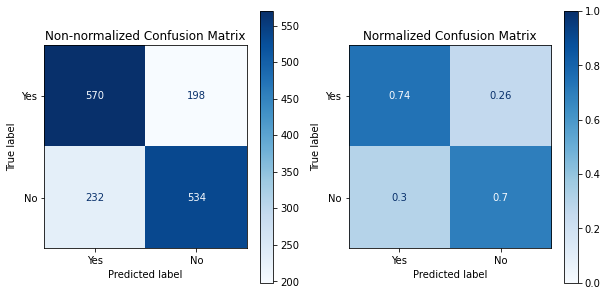

In [16]:
from sklearn.linear_model import LogisticRegression

start = time.time()
classifier6 = LogisticRegression(solver = 'saga', penalty = 'l1', C =100, max_iter = 100)
classifier6.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier6, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Logistic Reg.'] = {'Time' : time_taken,
                                          'True Positive' : tp,
                                          'True Negative' : tn,
                                          'False Positive' : fp,
                                          'False Negative' : fn}

In [ ]:
%store classification_result

As expected, the results from the classification via Logistic Regression only produces a slightly better result as compared to the SVM with linear kernel. This is the case even after the tuning of paramters `C` and `penalty`. In fact, we always get the warning that `the coef_ did not converge` regardless of how much the `max_iter` parameter was extended. This is probably due to the fact that the data set is not separated linearly, and hence separating the training data itself already produces huge errors even with various parameter tunings.

## Linear Discriminant Analysis (LDA)

Just like the Logistic Regression, LDA is also a linear classifier. Hence, it is also expected that this classifier will fare badly.

Time taken: 1885.63 seconds


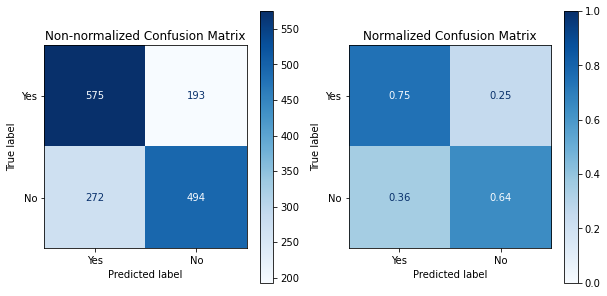

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
classifier7 = LinearDiscriminantAnalysis(solver = 'svd')
classifier7.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier7, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['LDA'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

In [29]:
%store classification_result

Stored 'classification_result' (dict)


While I have predicted that the LDA will fare badly compared to most other classifiers I have used previously, it is very unexpected that the overall error rate of LDA is so much worse than that of the Logistic Regression and the linear kernel SVM.

#### Logistic Regression vs LDA

After running the Logistic Regression and LDA classifiers, it is common to wonder why there is such a huge difference in accuracy between the two classifiers.

According to several websites (links under the Reference and Resources section), the difference in accuracy is mainly due to the different requirements required by both of these classifiers:

* In Logistic Regression, the distributions of the predictors do not matter. On the other hand, LDA assumes that the predictors follow a multivariate normal distribution.

* In Logistic Regression, there is no requirement in the predictors' within-group covariance matrices. This is hugely different compared to the LDA, where we assume that the sample predictors' (the training data's predictors in our case) within-group covariance matrices (namely $S_{Yes}$ and $S_{No}$) should be equal to the population predictors' covariance matrix (denoted $\Sigma$).

As we can see in our data, each "feature" or "predictor" actually represents the pixel values of each pixel, which means that they are very likely not normally distributed, nor do they have covariances equal to a "population" covariance. I believe that it is due to the restrictions of the LDA classifier and the failure of the predictor variables to meet the restrictions, LDA does not perform as well as the Logistic Regression in this case.

## Random Forest

The Random Forest Classification method is basically done by running Decision Tree Classification methods multiple times with slight tuning in data and features used. So before we dive straight into Random Forest Classification, let's first train our training data with a Decision Tree Classifier.

The general idea of running a Decision Tree Classifier is simple:

1) We have $m$ training data with $n$ features. In our case, this translates to our 3449 rows of training data and 65,536 features (pixels).

2) We start off at a root node with all our training data. Then, a feature is selected to split the training data into two. Eg. we start with the pixel (1,1) in each image. Images with pixel (1,1) values more than $\alpha$ will be transferred to a new node at the right side of the root node, and the rest will be transferred to a new node at the left side of the root node.

3) As of right now, we have transferred all of our training data into nodes that are either at the left or right nodes of the root node. Now, we want to check if any of the nodes contain only a single class, ie. the node contains images that are all of class 'Yes' or all of class 'No'. If this is the case, we are done with this node, no further action is needed to work on this node. Otherwise, we will need to repeat the process of step 2, this time selecting a different feature to classify our training data. Note that in every classification step, we are not allowed to transfer our data into a used node (ie. it has to be a new node every step).

4) After running steps 2 and 3 multiple times, we will arrive at a point where each and every non-empty nodes contain only a single class. At this point, we are done.

Note that the Decision Tree Classification method has the following problems:

* The time taken can be quite long depending on the data set, or the chosen training data. This is due to the fact that the "learning of optimal decision tree is NP-complete" (Wikipedia). This can be observed even when running the classification method on this data set, where the time taken to train the model and classify the testing data can go as fast as less than 2 minutes, to being as slow as more than 2 hours.

* Decision Trees tend to overfit. Recall that we will keep transferring data into new nodes until each node contains only one class of data. This becomes a problem when we put our test data into the decision tree since the properties of our test data is not exactly the same as those of the training data.

Time taken: 1266.3 seconds


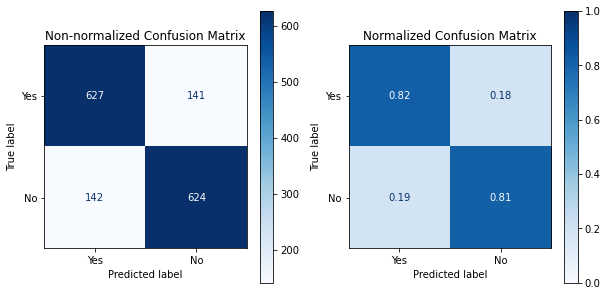

In [18]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
classifier8 = DecisionTreeClassifier(criterion = 'gini')
classifier8.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier8, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Decision Tree'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

In [40]:
%store classification_result

Stored 'classification_result' (dict)


After running the Decision Tree Classifier above, we have the following findings:

* The time taken for this to run is actually quite short. The only other classifier with such short time taken so far is the classifier that utilizes SVD properties.

* The results of this test is also very accurate. This is due to the fact that this classifier does not apply to strictly linear data, unlike the linear kernel SVM, Logistic Regression, and LDA

Now that we have tried out the Decision Tree Classifier, we move on to the Random Forest Classifier. The Random Forest Classifier is different from the Decision Tree Classifer in the following ways:

* Instead of using all features to classify our training data, the features used is selected at random.

* Instead of using all of our training data for classification, the training data is selected at random with replacement (aka bootstrapping). This means that there is a chance that we might select the same exact data (although it is less likely if the size of data is huge).

Now, with our new randomly selected subset of training data with randomly selected features, we run the Decision Tree Classifier once again. 

This time, however, we will be running all the above for a number of times (note the parameter `n_estimators` in the code below) before concluding with a model that is an average of all the models we got.

Time taken: 76.25 seconds


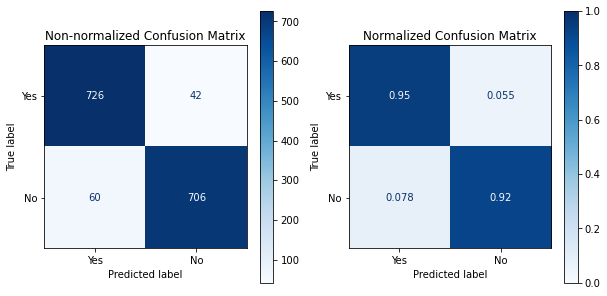

In [39]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
classifier9 = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
classifier9.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier9, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Random Forest'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

In [41]:
%store classification_result

Stored 'classification_result' (dict)


After running the Random Forest Classifier, the results that was obtained was very unexpected... in a good way. This classification method has given us the highest accuracy rate among all the methods we have used so far, and in the shortest amount of time too! 

A thing to note about the Random Forest Classifier is that, even after playing around with the `n_estimators` parameter with values 100, 200, 1000... The accuracy of the classifiers are highly similar, although the time taken to build the classifiers increases rapidly. Hence, I have decided to use `n_estimators = 100` since it gives us the best accuracy vs time trade-off.

## Neural Network

The code below will be used to separated our current training data into:

* $80\%$ for training

* $20\%$ for cross-validation

The reason for doing this will be explained in the following section.

Additionally, I will also convert our class vectors into a different format in order to fit into our neural network model.

In [ ]:
import random
import math

(NUM_OF_DATA, INPUT_NODES) = train_x.shape
OUTPUT_NODES = 2
LAYER1_NODES = 15000
LAYER2_NODES = 5000

# convert test and training y values from 'Yes' or 'No' to [1,0] or [0,1] respectively
train_y_01 = np.zeros((NUM_OF_DATA,2), dtype = int)
for i in range(NUM_OF_DATA):
    if train_y[i] == 'Yes':
        train_y_01[i][0] = 1
    else:
        train_y_01[i][1] = 1
test_y_01 = np.zeros((len(test_y_true), 2), dtype = int)
for i in range(len(test_y_true)):
    if test_y_true[i] == 'Yes':
        test_y_01[i][0] = 1
    else:
        test_y_01[i][1] = 1
        
# splitting training data into train and validation data sets
randomized_index = random.sample(list(range(NUM_OF_DATA)), NUM_OF_DATA)
training_num = math.ceil(0.8 * len(randomized_index))

nn_x_train = train_x[randomized_index[:training_num], :]
nn_y_train = train_y_01[randomized_index[:training_num], :]
nn_x_validation = train_x[randomized_index[training_num:], :]
nn_y_validation = train_y_01[randomized_index[training_num:], :]

TRAINING_COUNT = training_num
VALIDATION_COUNT = NUM_OF_DATA - TRAINING_COUNT

In the code below, we construct our neural network. Note that this entire thing here is going to be a trial run of training the data. In this trial run, we will separate our training data set into a train data set and validation data set, as done above. The reason for doing this is to track the prediction accuracies of the train data set and the validation data set at each EPOCH training iteration. We know that training the data with a small amount of iteration can lead to an underfitting model, which leads to bad predictions of both the training and test data sets. On the other hand, if we were to train the training data set for too long, it would lead us to overfitting of the data, in which case we get a very high accuracy (possibly even a $100\%$ accuracy) on the training set, but a less than optimum predictive accuracy on the test data set.

In [ ]:
import tensorflow.compat.v1 as tf

LEARNING_RATE = 5e-4
EPOCHS = 120
BATCH_SIZE = 100
LAMBDA = 0.01 # regularization parameter

# input layer
x = tf.placeholder(tf.float32, [None, INPUT_NODES])
# output layer
y = tf.placeholder(tf.float32, [None, OUTPUT_NODES])

# weights and bias for arcs from input to layer 1
W1 = tf.Variable(tf.truncated_normal([INPUT_NODES, LAYER1_NODES], stddev = 1e-3), name = 'W1')
b1 = tf.Variable(tf.zeros([LAYER1_NODES]), name = 'b1')
# weights and bias for arcs from layer 1 to layer 2
W2 = tf.Variable(tf.truncated_normal([LAYER1_NODES, LAYER2_NODES], stddev = 1e-3), name = 'W2')
b2 = tf.Variable(tf.zeros([LAYER2_NODES]), name = 'b2')
# # weights and bias for arcs from layer 2 to layer3
W3 = tf.Variable(tf.truncated_normal([LAYER2_NODES, OUTPUT_NODES], stddev = 1e-5), name = 'W3')
b3 = tf.Variable(tf.zeros([OUTPUT_NODES]), name = 'b3')

# going from one layer to the other via F(x) = ReLu(W*x + b)
input_to_layer1 = tf.nn.relu(tf.add(tf.matmul(x, W1), b1))
layer1_to_layer2 = tf.nn.relu(tf.add(tf.matmul(input_to_layer1, W2), b2))
layer2_to_output = tf.nn.softmax(tf.add(tf.matmul(layer1_to_layer2, W3), b3))

# cost function
y_clipped = tf.clip_by_value(layer2_to_output, 1e-8, 0.999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped) + (1 - y) * tf.log(1 - y_clipped), axis=1))

# add regularization to cost function
# regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
# cross_entropy = tf.reduce_mean(cross_entropy + LAMBDA * regularizers)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
optimizer = opt.minimize(cross_entropy)

# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(layer2_to_output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# define lists to track accuracies of training and validation data sets
train_accuracies = []
validation_accuracies = []

with tf.Session() as sess:
   # initialise the variables
    sess.run(init_op)
    total_batch = int(TRAINING_COUNT / BATCH_SIZE)
    for epoch in range(EPOCHS):
        avg_cost = 0
        randomized_index = random.sample(list(range(TRAINING_COUNT)), TRAINING_COUNT)
        for i in range(total_batch):
            batch_x = nn_x_train[randomized_index[(i*BATCH_SIZE):((i+1)*BATCH_SIZE)], :]
            batch_y = nn_y_train[randomized_index[(i*BATCH_SIZE):((i+1)*BATCH_SIZE)], :]
            _, c = sess.run([optimizer, cross_entropy], 
                         feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        training_acc = sess.run(accuracy, feed_dict={x: nn_x_train, y: nn_y_train})
        validation_acc = sess.run(accuracy, feed_dict = {x : nn_x_validation, y : nn_y_validation})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), end = ', ')
        print("Training Accuracy:", training_acc, end = ', ')
        print("Validation Accuracy:", validation_acc)
        train_accuracies.append(training_acc)
        validation_accuracies.append(validation_acc)
    test_y_pred_01 = sess.run(layer2_to_output, feed_dict = {x : test_x, y : test_y_01})
    print(sess.run(accuracy, feed_dict={x: test_x, y: test_y_01}))

The accuracy plot of Training vs Validation data set by EPOCH is shown below.

In [ ]:
epoch_count = list(range(1,EPOCHS+1))

plt.plot(epoch_count, train_accuracies, label = 'Training')
plt.plot(epoch_count, validation_accuracies, label = 'Validation')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracies by EPOCH')
plt.legend()

From the plot above, we can see that after running and backpropogating the training data, the accuracy of predicting the validation data set arrives at its peak at around 80 EPOCHS. Further training of the data would then lead the aforementioned case of overfitting, which is something we do not want.

In [ ]:
EPOCHS = validation_accuracies.index(max(validation_accuracies)) + 1

start = time.time()
with tf.Session() as sess:
   # initialise the variables
    sess.run(init_op)
    total_batch = int(NUM_OF_DATA / BATCH_SIZE)
    
    prev_cost = float('inf')
    
    for epoch in range(EPOCHS):
        avg_cost = 0
        randomized_index = random.sample(list(range(NUM_OF_DATA)), NUM_OF_DATA)
        for i in range(total_batch):
            batch_x = train_x[randomized_index[(i*BATCH_SIZE):((i+1)*BATCH_SIZE)], :]
            batch_y = train_y_01[randomized_index[(i*BATCH_SIZE):((i+1)*BATCH_SIZE)], :]
            _, c = sess.run([optimizer, cross_entropy], 
                         feed_dict={x: batch_x, y: batch_y})
            output = sess.run(layer2_to_output, feed_dict = {x : batch_x, y : batch_y})
            avg_cost += c / total_batch
            
        if prev_cost <= avg_cost:
            print('Cost Increased')
        prev_cost = avg_cost
        
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    test_y_pred_01 = sess.run(layer2_to_output, feed_dict = {x : test_x, y : test_y_01})
    print(sess.run(accuracy, feed_dict={x: test_x, y: test_y_01}))
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

The following is the resulting confusion matrix from predicting the test data set after building the optimum neural network model.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# convert the float values of test_y_pred_01 into a list of predictions 'Yes' or 'No'
test_y_pred = []
for i in range(len(test_y_pred_01)):
    if test_y_pred_01[i][0] > test_y_pred_01[i][1]:
        test_y_pred.append('Yes')
    else:
        test_y_pred.append('No')
        
# plot confusion matrix and record relevant data
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result['Neural Network'] = {'Time' : time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

### Effects of Parameter Tuning 
In training the best possible Neural Network model, there are certain parameters that needs to be tuned and experimented on. Here, I experimented with the tuning of the following parameters and observe the difference and changes in cost and accuracies of my training and validation data, and the time taken to run/compute 30 epochs. Obviously, the goal is to obtain a model that produces the best accuracies, but I will put the training time into consideration in this case.

###### Note: The following set of parameters are the default (control) settings used as the control group.

Batch size = 100  
Learning rate = `1e-3`  
Regularizer = L2  
Regularization parameter $\lambda$ = `1e-3`  
Dropout = No  
Optimizer = Adam  
Neural Network architecture: (16384 $\rightarrow$ 8000 $\rightarrow$ 1000 $\rightarrow$ 2) 

Results:  
Time taken to run 30 epochs = 3363.58 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.7267 (0.8649)  
Training cost after 30 epochs (min cost) = 10.2067 (8.8626)  
Validation accuracy after 30 epochs (max accuracy) = 0.6525 (0.8361)  
Validation cost after 30 epochs (min cost) = 8.8164 (8.8164)  
Test accuracy = 0.644  

#### Tuning Regularizer and Regularization Parameter $\lambda$
1) No Regularizer  
Results:  
Time taken to run 30 epochs = 2533.18 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9009 (0.9062)  
Training cost after 30 epochs (min cost) = 0.2292 (0.2271)  
Validation accuracy after 30 epochs (max accuracy) = 0.7969 (0.8450)  
Validation cost after 30 epochs (min cost) = 0.5357 (0.3721)  
Test accuracy = 0.793  

2) Regularizer = L2  
* $\lambda$ = `1e-2`  
Results:  
Time taken to run 30 epochs = 3657.4 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8592 (0.8781)  
Training cost after 30 epochs (min cost) = 34.5297 (34.5297)  
Validation accuracy after 30 epochs (max accuracy) = 0.8426 (0.8467)  
Validation cost after 30 epochs (min cost) = 33.5923 (33.5923)  
Test accuracy = 0.823  

* $\lambda$ = `1e-4`  
Results:  
Time taken to run 30 epochs = 3394.75 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8844 (0.8914)  
Training cost after 30 epochs (min cost) = 1.5366 (1.5366)  
Validation accuracy after 30 epochs (max accuracy) = 0.832 (0.8573)  
Validation cost after 30 epochs (min cost) = 1.6769 (1.6769)  
Test accuracy = 0.831 

* $\lambda$ = `1e-5`  
Results:  
Time taken to run 30 epochs = 3362.62 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9095 (0.9158)  
Training cost after 30 epochs (min cost) = 0.3833 (0.3080)  
Validation accuracy after 30 epochs (max accuracy) = 0.8409 (0.8515)  
Validation cost after 30 epochs (min cost) = 0.5458 (0.5104)  
Test accuracy = 0.842 

* $\lambda$ = `1e-6`  
Results:  
Time taken to run 30 epochs = 3321.91 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8443 (0.8740)  
Training cost after 30 epochs (min cost) = 0.3692 (0.3597)  
Validation accuracy after 30 epochs (max accuracy) = 0.8132 (0.8230)  
Validation cost after 30 epochs (min cost) = 0.5405 (0.5347)  
Test accuracy = 0.797  

3) Regularizer = L1
* $\lambda$ = `1e-2`  
Results:  
Time taken to run 30 epochs = 3347.99 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.5124 (0.6068)  
Training cost after 30 epochs (min cost) = 142.2962 (142.2962)  
Validation accuracy after 30 epochs (max accuracy) = 0.4543 (0.6860)  
Validation cost after 30 epochs (min cost) = 177.0455 (144.0132)  
Test accuracy = 0.472  

* $\lambda$ = `1e-3`  
 * No additional changes  
Results:  
Time taken to run 30 epochs = 3350.78 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.5165 (0.7740)  
Training cost after 30 epochs (min cost) = 236.8862 (39.1273)  
Validation accuracy after 30 epochs (max accuracy) = 0.5016 (0.7945)  
Validation cost after 30 epochs (min cost) = 144.092 (36.9355)  
Test accuracy = 0.501  

 * Learning rate $\rightarrow$ `1e-4`  
Results:  
Time taken to run 30 epochs = 3374.35 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8430 (0.8681)  
Training cost after 30 epochs (min cost) = 444.9875 (444.9875)  
Validation accuracy after 30 epochs (max accuracy) = 0.8385 (0.8491)  
Validation cost after 30 epochs (min cost) = 436.8685 (436.8685)  
Test accuracy = 0.853  

* $\lambda$ = `1e-4`  
Results:  
Time taken to run 30 epochs = 3378.91 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.4992 (0.8186)  
Training cost after 30 epochs (min cost) = 49.011 (49.011)  
Validation accuracy after 30 epochs (max accuracy) = 0.5131 (0.8279)  
Validation cost after 30 epochs (min cost) = 47.9869 (47.9869)  
Test accuracy = 0.501  

* $\lambda$ = `1e-5`  
 * No additional changes  
Results:  
Time taken to run 30 epochs = 3523.74 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.7709 (0.8388)  
Training cost after 30 epochs (min cost) = 11.9449 (10.8960)  
Validation accuracy after 30 epochs (max accuracy) = 0.5979 (0.8320)  
Validation cost after 30 epochs (min cost) = 17.7728 (10.8391)  
Test accuracy = 0.598  

 * Learning rate $\rightarrow$ `1e-4`  
Results:  
Time taken to run 30 epochs =  seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8477 (0.9068)  
Training cost after 30 epochs (min cost) = 12.5763 (10.9749)  
Validation accuracy after 30 epochs (max accuracy) = 0.8002 (0.8532)  
Validation cost after 30 epochs (min cost) = 13.0399 (12.2437)  
Test accuracy = 0.791

Notes:  
1) In experimenting with different $\lambda$'s for L1 regularization while keeping the rest of the default parameters, it is found that the results produced are awful! The accuracies and cost values fluctuate constantly and barely converge. The steps to overcome this issue is to decrease the learning rate of the model, as shown above when results were generally better when the learning rate is decreased to `1e-4`. However, it seems that L2 regularized-models tend to perform better, and hence we'll be sticking with L2 regularization for the rest of the experimentations.  
2) In the case where no regularizers are used, we notice that the training accuracy tends to do well, but the corresponding validation and test accuracies seem to take a slight hit, especially when compared to the L2 regularizer with $\lambda = $ `1e-4`. This is the expected outcome as the main reason regularizers are used is to generalize a model better and pervent overfitting of the training set. It is also notable that the training time when regularizers are not used is significantly shorter.  
3) In cases where we have the value of $\lambda$ set too large, we tend to observe almost no learning in the Neural Network model. In these cases, while the cost values constantly decreases, there tends to be no change in accuracies in the training and validation data. The fix to this problem is to decrease the value of $\lambda$. The best results is obtained when we use the L2 regularizer and set $\lambda$ = `1e-4` or `1e-5`. There seems to be a lot more fluctuations and lower accuracy values if we have $\lambda$ go any smaller, although things might change if we also switch out certain other parameters.

#### Tuning Batch Size and Learning Rate
* Batch size = 8  
 * learning rate $\rightarrow$ `1e-7`, $\lambda \rightarrow$ `1e-4`  
Results:  
Time taken to run 30 epochs = 38092.16 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9215 (0.9215)  
Training cost after 30 epochs (min cost) = 2.3362 (2.3362)  
Validation accuracy after 30 epochs (max accuracy) = 0.8238 (0.8303)  
Validation cost after 30 epochs (min cost) = 3.5128 (3.4253)  
Test accuracy = 0.812  

 * learning rate $\rightarrow$ `1e-7`, $\lambda \rightarrow$ `1e-5` ## Low validation accuracy, overfitting  
Results:  
Time taken to run 30 epochs = 38599.7 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9162 (0.9162)  
Training cost after 30 epochs (min cost) = 1.2777 (1.2777)  
Validation accuracy after 30 epochs (max accuracy) = 0.8254 (0.8263)  
Validation cost after 30 epochs (min cost) = 2.388 (2.388)  
Test accuracy = 0.816  

* Batch size = 32  
 * $\lambda \rightarrow$ `1e-5`    
Results:  
Time taken to run 30 epochs = 9598.19 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.5041 (0.7917)  
Training cost after 30 epochs (min cost) = 0.8199 (0.7234)  
Validation accuracy after 30 epochs (max accuracy) = 0.4918 (0.7798)  
Validation cost after 30 epochs (min cost) = 0.8210 (0.8210)  
Test accuracy = 0.499 

 * Learning Rate $\rightarrow$ `1e-4`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs = 9895.41 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9062 (0.9103)  
Training cost after 30 epochs (min cost) = 0.3481 (0.3481)  
Validation accuracy after 30 epochs (max accuracy) = 0.8344 (0.8483)  
Validation cost after 30 epochs (min cost) = 0.6318 (0.5725)  
Test accuracy = 0.83 

 * Learning Rate $\rightarrow$ `1e-5`, $\lambda \rightarrow$ `1e-4`  
Results:  
Time taken to run 30 epochs =  seconds  
Training accuracy after 30 epochs (max accuracy) =  ()  
Training cost after 30 epochs (min cost) =  ()  
Validation accuracy after 30 epochs (max accuracy) =  ()  
Validation cost after 30 epochs (min cost) =  ()  
Test accuracy =  

 * Learning Rate $\rightarrow$ `1e-5`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs = 9721.24 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.9293 (0.9492)  
Training cost after 30 epochs (min cost) = 1.6688 (1.1503)  
Validation accuracy after 30 epochs (max accuracy) = 0.8238 (0.8540)  
Validation cost after 30 epochs (min cost) = 8.377 (5.152)  
Test accuracy =  0.828

* Batch size = 100  
 * Learning rate $\rightarrow$ `1e-2`  
Results:  
Time taken to run 30 epochs = 3447.4 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.5004 (0.5004)  
Training cost after 30 epochs (min cost) = 7.6975 (7.9625)  
Validation accuracy after 30 epochs (max accuracy) = 0.5 (0.5)  
Validation cost after 30 epochs (min cost) = 7.6813 (7.6670)  
Test accuracy = 0.501  
Both training and validation cost values has been constantly decreasing, but both their accuracies have been stuck constant since epoch 1.

 * Learning rate $\rightarrow$ `1e-4`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs = 3366.57 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8791 (0.8940)  
Training cost after 30 epochs (min cost) = 2.1333 (1.6987)  
Validation accuracy after 30 epochs (max accuracy) = 0.8483 (0.8654)  
Validation cost after 30 epochs (min cost) = 2.9694 (2.7154)  
Test accuracy = 0.834  

 * Learning rate $\rightarrow$ `1e-5`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs =  seconds  
Training accuracy after 30 epochs (max accuracy) =  ()  
Training cost after 30 epochs (min cost) =  ()  
Validation accuracy after 30 epochs (max accuracy) =  ()  
Validation cost after 30 epochs (min cost) =  ()  
Test accuracy =   



* Batch size = 300
 * $\lambda \rightarrow$ `1e-5`   
 Results:  
Time taken to run 30 epochs = 1916.4 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8808 (0.8808)  
Training cost after 30 epochs (min cost) = 0.6317 (0.6317)  
Validation accuracy after 30 epochs (max accuracy) = 0.8312 (0.8336)  
Validation cost after 30 epochs (min cost) = 0.8687 (0.8687)  
Test accuracy = 0.829  

 * Learning Rate $\rightarrow$ `1e-2`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs = 1526.43 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8039 (0.8080)  
Training cost after 30 epochs (min cost) = 4.6822 (4.6337)  
Validation accuracy after 30 epochs (max accuracy) = 0.7790 (0.8328)  
Validation cost after 30 epochs (min cost) = 4.7957 (4.6911)  
Test accuracy = 0.791 

 * Learning Rate $\rightarrow$ `1e-4`, $\lambda \rightarrow$ `1e-5`  
Results:  
Time taken to run 30 epochs = 1568.31 seconds  
Training accuracy after 30 epochs (max accuracy) = 0.8773 (0.8773)  
Training cost after 30 epochs (min cost) = 3.6781 (3.6781)  
Validation accuracy after 30 epochs (max accuracy) = 0.7561 (0.8385)  
Validation cost after 30 epochs (min cost) = 10.6387 (4.7872)  
Test accuracy = 0.791 

Notes:  
1) In the paper "Don't Decay the Learning Rate, Increase the Batch Size" by Smith, Kindermans, Ying and Le, they wrote:  
*** 
"When we decay the learning rate, the noise scale falls, enabling us to converge to the minimum of the cost function. However we can achieve the same reduction in noise scale at constant learning rate by increasing the batch size. The main contribution of this work is to show that it is possible to make efficient use of vast training batches, if one increases the batch size during training at constant learning rate until $B \sim N/10$ (batch size around 1/10 of training data size). After this point, we revert to the use of decaying learning rates." 
***  
Therefore, I had to play around with various different batch sizes and learning rates in this section to observe how the model fares with different combinations.


#### Tuning Optimizer

#### Adding Dropout

#### Playing Around With Number of Neurons and Hidden Layers



In [ ]:
%store classification_result

## Time and Accuracy Comparisons

The following figure is used to compare the difference in error rate, false positive rate, false negative rate, and time of each of the used method.

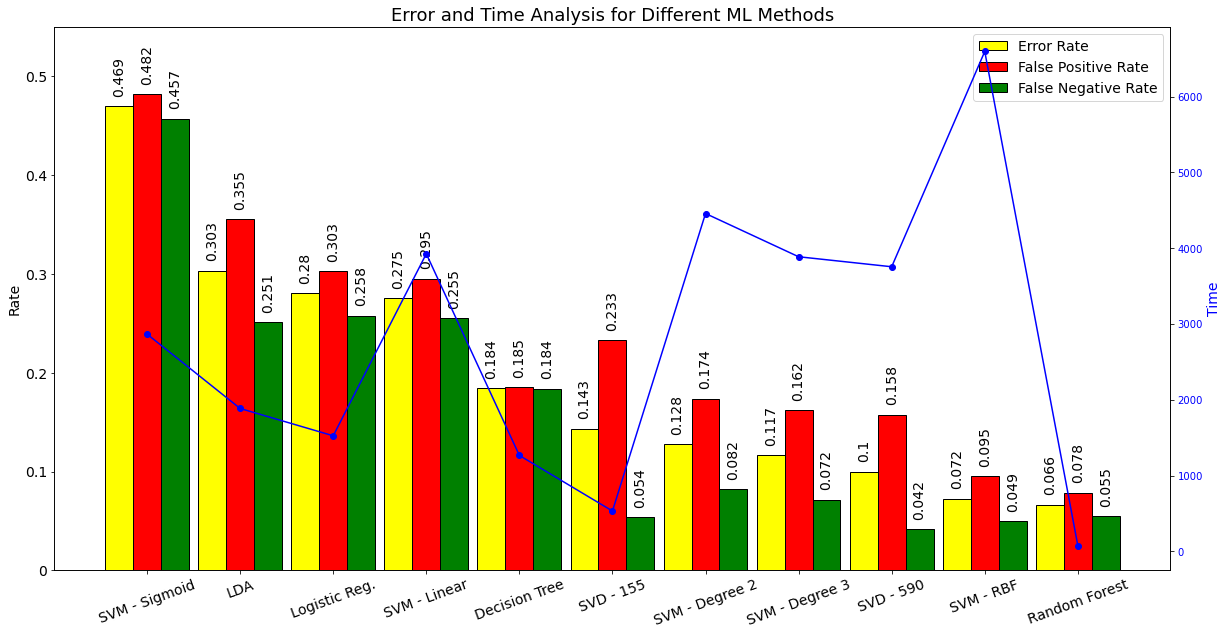

In [45]:
df = pd.DataFrame.from_dict(classification_result, orient = 'index')
df = df.reset_index()
total_sum = df['True Positive'] + df['True Negative'] + df['False Negative'] + df['False Positive']
df = df.assign(ErrorRate = (df['False Negative'] + df['False Positive']) / total_sum,
              TP_rate = df['True Positive'] / (df['True Positive'] + df['False Negative']),
              TN_rate = df['True Negative'] / (df['True Negative'] + df['False Positive']),
              FP_rate = df['False Positive'] / (df['True Negative'] + df['False Positive']),
              FN_rate = df['False Negative'] / (df['True Positive'] + df['False Negative']))
df = df.rename(columns = {'index' : 'Method', 'ErrorRate' : 'Error %', 'TP_rate' : 'True Positive %',
                         'TN_rate' : 'True Negative %', 'FP_rate' : 'False Positive %', 'FN_rate' : 'False Negative %'})
df = df.sort_values('Error %', ascending = False)

ind = np.arange(len(df))
width = 0.3

method = np.asarray(df['Method'])
time_taken = np.asarray(df['Time'])
fp = np.asarray(df['False Positive %'])
fn = np.asarray(df['False Negative %'])
err = np.asarray(df['Error %'])

fig, ax1 = plt.subplots(figsize = (20,10))
ax1.bar(ind - width, err, width,color = 'yellow', edgecolor = 'black')
ax1.bar(ind, fp, width, color = 'red', edgecolor = 'black')
ax1.bar(ind + width, fn, width, color = 'green', edgecolor = 'black')
ax1.legend(['Error Rate', 'False Positive Rate', 'False Negative Rate'], fontsize = 14)
ax1.set_ylim(0,0.55)
ax1.set_ylabel('Rate', fontsize = 14)
ax1.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize = 14)
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(method, rotation = 20, fontsize = 14)
ax1.set_title('Error and Time Analysis for Different ML Methods', fontsize = 18)

for i in range(len(df)):
    ax1.text(ind[i] - width, err[i] + 0.01, str(round(err[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')
    ax1.text(ind[i], fp[i] + 0.01, str(round(fp[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')
    ax1.text(ind[i] + width, fn[i] + 0.01, str(round(fn[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('Time', color=color, fontsize = 14)  # we already handled the x-label with ax1
ax2.plot(method, time_taken, 'o-b')
# ax2.set_ylim(0,1300)
# ax2.set_yticklabels(list(range(0,1201,200)), fontsize = 14)
ax2.tick_params(axis='y', labelcolor=color)

## Key Takeaways

## References and Resources

Plots:
* https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side

* https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

* https://matplotlib.org/examples/api/barchart_demo.html

SVM:
* https://scikit-learn.org/stable/modules/svm.html

* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

* https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm

* https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

* https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f#:~:text=The%20%E2%80%9Ctrick%E2%80%9D%20is%20that%20kernel,the%20data%20by%20these%20transformed

* http://www.cs.cmu.edu/~aarti/Class/10601/slides/svm_11_22_2011.pdf

Logistic Regression:
* https://realpython.com/logistic-regression-python/

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

* https://www.knime.com/blog/regularization-for-logistic-regression-l1-l2-gauss-or-laplace#:~:text=Regularization%20for%20Logistic%20Regression%3A%20L1%2C%20L2%2C%20Gauss%20or%20Laplace%3F,-Mon%2C%2003%2F12&text=Regularization%20can%20be%20used%20to%20avoid%20overfitting.&text=In%20other%20words%3A%20regularization%20can,from%20overfitting%20the%20training%20dataset

* https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul

LDA:
* https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Logistic Regression vs LDA:
* https://stats.stackexchange.com/questions/95247/logistic-regression-vs-lda-as-two-class-classifiers

Random Forest
* https://www.datacamp.com/community/tutorials/random-forests-classifier-python

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

* https://en.wikipedia.org/wiki/Decision_tree_learning

* https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

Neural Network:
* https://adventuresinmachinelearning.com/python-tensorflow-tutorial/

* https://adventuresinmachinelearning.com/improve-neural-networks-part-1/

* https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/

* https://en.wikipedia.org/wiki/Backpropagation

* https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

* https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html

* https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer

* https://towardsdatascience.com/pruning-deep-neural-network-56cae1ec5505

* https://towardsdatascience.com/how-to-train-neural-network-faster-with-optimizers-d297730b3713

* https://stats.stackexchange.com/questions/345990/why-does-the-loss-accuracy-fluctuate-during-the-training-keras-lstm

* https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating

* https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

* https://stackoverflow.com/questions/45587378/how-to-get-predicted-values-in-keras

* https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

* https://openreview.net/pdf?id=B1Yy1BxCZ